# Hedgecraft Part 1: Building an Optimal Portfolio with Network Science

What is the optimal way of constructing a portfolio? A portfolio that (1) consistently generates wealth while minimizing potential losess and (2) is robust against large market fluctuations and economic downturns? I will explore these questions in some depth in a three-part ***Hedgecraft*** series. While the series is aimed at a technical audience, my intentions are to break the technical concepts down into digestible bit-sized pieces suitable for a general audience, institutional investors, and others alike. The approach documented in this notebook (to my knowledge) is novel. To this end, the penultimate goal of the project is an end-to-end FinTech/Portfolio Management product.

## Summary

Using insights from [Network Science](https://en.wikipedia.org/wiki/Network_science), we build a [centrality-based](https://en.wikipedia.org/wiki/Centrality) risk model for generating portfolio asset weights. The model is trained with the daily prices of 31 stocks from 2006-2014 and validated in years 2015, 2016, and 2017. As a benchmark, we compare the model with a portolfio constructed with [Modern Portfolio Theory (MPT)](https://en.wikipedia.org/wiki/Modern_portfolio_theory). Our proposed asset allocation algorithm significantly outperformed both the DIJIA and S&P500 indexes in every validation year with a 19.29% annual return rate, a 12.6% annual standard deviation, and a Sharpe ratio of 1.38. In comparison, the MPT portfolio had a 9.64% annual return rate, a 16.4% annual standard deviation, and a Sharpe ratio of 0.47.


## Background

In this series we play the part of an Investment Data Scientist at [Bridgewater Associates](https://www.bridgewater.com/) performing a go/no go analysis on a new idea for risk-weighted asset allocation. Our aim is to develop a network-based model for generating asset weights such that the probability of losing money in any given year is minimized. We've heard down the grapevine that all go-descisions will be presented to Dalio's inner circle at the end of the week and will likely be subject to intense scrutiny. As such, we work with a few highly correlated assets with strict go/no go criteria. We build the model using the daily prices of each stock (with a few replacements\*) in the Dow Jones Industrial Average (DJIA). If our recommended portfolio either (1) loses money in **any** year, (2) does not outperform the market **every** year, or (3) does not outperform the MPT portfolio---the decision is no go.

* We replaced Visa (V), DowDuPont (DWDP), and Walgreens (WBA) with three alpha generators: Google (GOOGL), Amazon (AMZN), and Altaba (AABA) and, for the sake of model building, one poor performing stock: General Electric (GE). The dataset is found on [Kaggle](https://www.kaggle.com/szrlee/stock-time-series-20050101-to-20171231/home).

### Asset Diversification and Allocation

The building blocks of a portfolio are assets (resources with economic value expected to increase over time). Each asset belongs to one of seven primary asset classes: cash, equitiy, fixed income, commodities, real-estate, alternative assets, and more recently, digital (such as cryptocurrency and blockchain). Within each class are different asset types. For example: stocks, index funds, and equity mutual funds all belong to the equity class while gold, oil, and corn belong to the commodities class. An emerging consensus in the financial sector is this: a portfolio containing assets of many classes and types hedges against potential losses by increasing the number of revenue streams. In general the more diverse the portfolio the less likely it is to lose money. Take stocks for example. A diversified stock portfolio contains positions in multiple sectors. We call this *asset diversification*, or more simply *diversification*. Below is a table summarizing the asset classes and some of their respective types.

Cash | Equity | Fixed Income | Commodities | Real-Estate | Alternative Assets | Digital |
-----|--------|--------------|-------------|-------------|--------------------|---------|
US Dollar | US Stocks | US Bonds | Gold | REIT's | Structured Credit | Cryptocurrencies
Japenese Yen | Foreign Stocks | Foreign Bonds | Oil | Commerical Properties | Liquidations | Security Tokens
Chinese Yaun | Index Funds | Deposits | Wheat | Land | Aviation Assets | Online Stores
UK Pound | Mutual Funds | Debentures | Corn | Industrial Properties | Collectables | Online Media
 &bull;<p> | &bull;<p> | &bull;<p> | &bull;<p> | &bull;<p> | &bull;<p> | &bull;<p> |
 &bull;<p> | &bull;<p> | &bull;<p> | &bull;<p> | &bull;<p> | &bull;<p> | &bull;<p> |

**An investor solves the following (asset allocation) problem: given X dollars and N assets find the best possible way of breaking X into N pieces.** By "best possible" we mean maximizing our returns subject to minimizing the risk of our initial investment. In other words, we aim to consistently grow X irrespective of the overall state of the market. In what follows, we explore provocative insights by [Ray Dalio](https://en.wikipedia.org/wiki/Ray_Dalio) and others on portfolio construction.

![The Holy Grail of Finance](https://i1.wp.com/macro-ops.com/wp-content/uploads/2017/09/The-Holy-Grail.jpg)
Source: [Principles by Ray Dalio (Summary)](https://static1.squarespace.com/static/56f1d1777da24fd2594c0f51/t/5a35b71e652dea7bc2f59ef6/1513469734986/You+Exec+-+Principles+by+Ray+Dalio.pdf)

The above chart depicts the behaviour of a portfolio with increasing diversification. Along the x-axis is the number of asset types. Along the y-axis is how "spread out" the annual returns are. A lower annual standard deviation indicates smaller fluctuations in each revenue stream, and in turn a diminished risk exposure. The "Holy Grail" so to speak, is to (1) find the largest number of assets that are the **least** correlated and (2) allocate X dollars to those assets such that the probability of losing money any given year is minimized. The underlying principle is this: the portfolio most robust against large market fluctuations and economic downturns is a portfolio with assets that are the **most independent** of each another.

# Exploratory Data Analysis and Cleaning

Before we cdive into the meat of our asset allocation model, we first explore, clean, and preprocess our historical price data for time-series analyses. In this section we complete the following.

- [X] Observe how many rows and columns are in our dataset and what they mean.
- [X] Observe the datatypes of the columns and update them if needed.
- [X] Take note of how the data is structured and what preprocessing will be necessary for time-series analyses.
- [X] Deal with any missing data accordingly.
- [X] Rename the stock tickers to the company names for readability.

In [2]:
#import data manipulation (pandas) and numerical manipulation (numpy) modules
import pandas as pd
import numpy as np

#silence warnings
import warnings
warnings.filterwarnings("ignore")

#reads the csv file into pandas DataFrame
df = pd.read_csv("all_stocks_2006-01-01_to_2018-01-01.csv")

#prints first 5 rows of the DataFrame
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,77.76,79.35,77.24,79.11,3117200,MMM
1,2006-01-04,79.49,79.49,78.25,78.71,2558000,MMM
2,2006-01-05,78.41,78.65,77.56,77.99,2529500,MMM
3,2006-01-06,78.64,78.90,77.64,78.63,2479500,MMM
4,2006-01-09,78.50,79.83,78.46,79.02,1845600,MMM


* ```Date```: date (yyyy-mm-dd)
* ```Open```: daily opening prices (USD)
* ```High```: daily high prices (USD)
* ```Low```: daily low prices (USD)
* ```Close```: daily closing prices (USD)
* ```Volume``` daily volume (number of shares traded)
* ```Name```: ticker (abbreviates company name)

In [3]:
#prints last 5 rows
df.tail()

,Date,Open,High,Low,Close,Volume,Name
93607,2017-12-22,71.42,71.87,71.22,71.58,10979165,AABA
93608,2017-12-26,70.94,71.39,69.63,69.86,8542802,AABA
93609,2017-12-27,69.77,70.49,69.69,70.06,6345124,AABA
93610,2017-12-28,70.12,70.32,69.51,69.82,7556877,AABA
93611,2017-12-29,69.79,70.13,69.43,69.85,6613070,AABA


In [4]:
#prints information about the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93612 entries, 0 to 93611
Data columns (total 7 columns):
Date      93612 non-null object
Open      93587 non-null float64
High      93602 non-null float64
Low       93592 non-null float64
Close     93612 non-null float64
Volume    93612 non-null int64
Name      93612 non-null object
dtypes: float64(4), int64(1), object(2)
memory usage: 5.0+ MB


Some observations:

* The dataset has 93,612 rows and 7 columns. 
* The ```Date``` column is **not** a DateTime object (we need to change this).
* For time-series analyses we need to preprocess the data (we address this in the proceeding section).
* There are missing values in the ```Open```, ```High```, and ```Low``` columns (we adress this after preprocessing the data).
* We also want to map the tickers (e.g., MMM) to the company names (e.g., 3M).
* Finally, we need to set the index as the date.

In [5]:
#changes Date column to a DateTime object
df['Date'] = pd.to_datetime(df['Date'])

In [6]:
#prints unique tickers in the Name column
print(df['Name'].unique())

['MMM' 'AXP' 'AAPL' 'BA' 'CAT' 'CVX' 'CSCO' 'KO' 'DIS' 'XOM' 'GE' 'GS'
 'HD' 'IBM' 'INTC' 'JNJ' 'JPM' 'MCD' 'MRK' 'MSFT' 'NKE' 'PFE' 'PG' 'TRV'
 'UTX' 'UNH' 'VZ' 'WMT' 'GOOGL' 'AMZN' 'AABA']


In [7]:
#dictionary of tickers and their respective company names
ticker_mapping = {'AABA':'Altaba', 
                  'AAPL':'Apple', 
                  'AMZN': 'Amazon',
                  'AXP':'American Express',
                  'BA':'Boeing', 
                  'CAT':'Caterpillar',
                  'MMM':'3M', 
                  'CVX':'Chevron', 
                  'CSCO':'Cisco Systems',
                  'KO':'Coca-Cola', 
                  'DIS':'Walt Disney', 
                  'XOM':'Exxon Mobil',
                  'GE': 'General Electric',
                  'GS':'Goldman Sachs',
                  'HD': 'Home Depot',
                  'IBM': 'IBM',
                  'INTC': 'Intel',
                  'JNJ':'Johnson & Johnson',
                  'JPM':'JPMorgan Chase',
                  'MCD':'Mcdonald\'s',
                  'MRK':'Merk',
                  'MSFT':'Microsoft',
                  'NKE':'Nike',
                  'PFE':'Pfizer',
                  'PG':'Procter & Gamble',
                  'TRV':'Travelers',
                  'UTX':'United Technologies',
                  'UNH':'UnitedHealth',
                  'VZ':'Verizon',
                  'WMT':'Walmart',
                  'GOOGL':'Google'}

#changes the tickers in df to the company names
df['Name'] = df['Name'].map(ticker_mapping)

In [8]:
#sets the Date column as the index
df.set_index('Date', inplace=True)

# Preprocessing for Time-Series Analysis

In this section we do the following.

1. Break the data in two pieces: historical prices from 2006-2014 (``df_train``) and from 2015-2017 (``df_validate``). We build our model portfolio using the former and test it with the latter.
<br/><br/>
2. We add a column to ``df_train`` recording the difference between the daily closing and opening prices ```Close_diff```.
<br/><br/>
3. We create a seperate DataFrame for the ``Open``, ``High``, ``Low``, ``Close``, and ``Close_diff`` time-series.
    * Pivot the tickers in the ``Name`` column of ``df_train`` to the column names of the above DataFrames and set the values as the daily prices 
<br/><br/>
4. Transform each time-series so that it's stationary.
    * We do this by detrending with the pd.diff() method
<br/><br/>
5. Finally, remove the missing data.

In [9]:
#traning dataset
df_train = df.loc['2006-01-03':'2015-01-01']
df_train.tail()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2014-12-24,50.19,50.92,50.19,50.65,5962870,Altaba
2014-12-26,50.65,51.06,50.61,50.86,5170048,Altaba
2014-12-29,50.67,51.01,50.51,50.53,6624489,Altaba
2014-12-30,50.35,51.27,50.35,51.22,10703455,Altaba
2014-12-31,51.54,51.68,50.46,50.51,9305013,Altaba


In [10]:
#testing dataset
df_validate = df.loc['2015-01-01':'2017-12-31']
df_validate.tail()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2017-12-22,71.42,71.87,71.22,71.58,10979165,Altaba
2017-12-26,70.94,71.39,69.63,69.86,8542802,Altaba
2017-12-27,69.77,70.49,69.69,70.06,6345124,Altaba
2017-12-28,70.12,70.32,69.51,69.82,7556877,Altaba
2017-12-29,69.79,70.13,69.43,69.85,6613070,Altaba


It's always a good idea to check we didn't lose any data after the split.

In [11]:
#returns True if no data was lost after the split and False otherwise.
df_train.shape[0] + df_validate.shape[0] == df.shape[0]

True

In [12]:
# sets each column as a stock and every row as a daily closing price
df_validate = df_validate.pivot(columns='Name', values='Close')

In [13]:
df_validate.head()

Name,3M,Altaba,Amazon,American Express,Apple,Boeing,Caterpillar,Chevron,Cisco Systems,Coca-Cola,...,Microsoft,Nike,Pfizer,Procter & Gamble,Travelers,United Technologies,UnitedHealth,Verizon,Walmart,Walt Disney
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,164.06,50.17,308.52,93.02,109.33,129.95,91.88,112.58,27.61,42.14,...,46.76,47.52,31.33,90.44,105.44,115.04,100.78,46.96,85.90,93.75
2015-01-05,160.36,49.13,302.19,90.56,106.25,129.05,87.03,108.08,27.06,42.14,...,46.32,46.75,31.16,90.01,104.17,113.12,99.12,46.57,85.65,92.38
2015-01-06,158.65,49.21,295.29,88.63,106.26,127.53,86.47,108.03,27.05,42.46,...,45.65,46.48,31.42,89.60,103.24,111.52,98.92,47.04,86.31,91.89
2015-01-07,159.80,48.59,298.42,90.30,107.75,129.51,87.81,107.94,27.30,42.99,...,46.23,47.44,31.85,90.07,105.00,112.73,99.93,46.19,88.60,92.83
2015-01-08,163.63,50.23,300.46,91.58,111.89,131.80,88.71,110.41,27.51,43.51,...,47.59,48.53,32.50,91.10,107.18,114.65,104.70,47.18,90.47,93.79


In [14]:
#creates a new column with the difference beteween the closing and opening prices
df_train['Close_Diff'] = df_train.loc[:,'Close'] - df_train.loc[:,'Open']

In [15]:
df_train.head()

,Open,High,Low,Close,Volume,Name,Close_Diff
Date,,,,,,,
2006-01-03,77.76,79.35,77.24,79.11,3117200,3M,1.35
2006-01-04,79.49,79.49,78.25,78.71,2558000,3M,-0.78
2006-01-05,78.41,78.65,77.56,77.99,2529500,3M,-0.42
2006-01-06,78.64,78.90,77.64,78.63,2479500,3M,-0.01
2006-01-09,78.50,79.83,78.46,79.02,1845600,3M,0.52


In [16]:
#creates a DataFrame for each time-series (see In [11])
df_train_close = df_train.pivot(columns='Name', values='Close')
df_train_open = df_train.pivot(columns='Name', values='Open')
df_train_close_diff = df_train.pivot(columns='Name', values='Close_Diff')
df_train_high = df_train.pivot(columns='Name', values='High')
df_train_low = df_train.pivot(columns='Name', values='Low')

#makes a copy of the traning dataset
df_train_close_copy = df_train_close.copy()

df_train_close.head()

Name,3M,Altaba,Amazon,American Express,Apple,Boeing,Caterpillar,Chevron,Cisco Systems,Coca-Cola,...,Microsoft,Nike,Pfizer,Procter & Gamble,Travelers,United Technologies,UnitedHealth,Verizon,Walmart,Walt Disney
Date,,,,,,,,,,,,,,,,,,,,,
2006-01-03,79.11,40.91,47.58,52.58,10.68,70.44,57.80,59.08,17.45,20.45,...,26.84,10.74,23.78,58.78,45.99,56.53,61.73,30.38,46.23,24.40
2006-01-04,78.71,40.97,47.25,51.95,10.71,71.17,59.27,58.91,17.85,20.41,...,26.97,10.69,24.55,58.89,46.50,56.19,61.88,31.27,46.32,23.99
2006-01-05,77.99,41.53,47.65,52.50,10.63,70.33,59.27,58.19,18.35,20.51,...,26.99,10.76,24.58,58.70,46.95,55.98,61.69,31.63,45.69,24.41
2006-01-06,78.63,43.21,47.87,52.68,10.90,69.35,60.45,59.25,18.77,20.70,...,26.91,10.72,24.85,58.64,47.21,56.16,62.90,31.35,45.88,24.74
2006-01-09,79.02,43.42,47.08,53.99,10.86,68.77,61.55,58.95,19.06,20.80,...,26.86,10.88,24.85,59.08,47.23,56.80,61.40,31.48,45.71,25.00


## Detrending and Additional Data Cleaning


In [17]:
#creates a list of stocks
stocks = df_train_close.columns.tolist()

#list of training DataFrames containing each time-series
df_train_list = [df_train_close, df_train_open, df_train_close_diff, df_train_high, df_train_low]

#detrends each time-series for each DataFrame
for df in df_train_list:
    for s in stocks:
        df[s] = df[s].diff()

In [18]:
df_train_close.head()

Name,3M,Altaba,Amazon,American Express,Apple,Boeing,Caterpillar,Chevron,Cisco Systems,Coca-Cola,...,Microsoft,Nike,Pfizer,Procter & Gamble,Travelers,United Technologies,UnitedHealth,Verizon,Walmart,Walt Disney
Date,,,,,,,,,,,,,,,,,,,,,
2006-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-04,-0.40,0.06,-0.33,-0.63,0.03,0.73,1.47,-0.17,0.40,-0.04,...,0.13,-0.05,0.77,0.11,0.51,-0.34,0.15,0.89,0.09,-0.41
2006-01-05,-0.72,0.56,0.40,0.55,-0.08,-0.84,0.00,-0.72,0.50,0.10,...,0.02,0.07,0.03,-0.19,0.45,-0.21,-0.19,0.36,-0.63,0.42
2006-01-06,0.64,1.68,0.22,0.18,0.27,-0.98,1.18,1.06,0.42,0.19,...,-0.08,-0.04,0.27,-0.06,0.26,0.18,1.21,-0.28,0.19,0.33
2006-01-09,0.39,0.21,-0.79,1.31,-0.04,-0.58,1.10,-0.30,0.29,0.10,...,-0.05,0.16,0.00,0.44,0.02,0.64,-1.50,0.13,-0.17,0.26


In [19]:
#counts the missing values in each column
df_train_close.isnull().sum()

Name
3M                     1
Altaba                 3
Amazon                 3
American Express       1
Apple                  3
Boeing                 1
Caterpillar            1
Chevron                1
Cisco Systems          3
Coca-Cola              1
Exxon Mobil            1
General Electric       1
Goldman Sachs          1
Google                 3
Home Depot             1
IBM                    1
Intel                  3
JPMorgan Chase         1
Johnson & Johnson      1
Mcdonald's             1
Merk                   3
Microsoft              3
Nike                   1
Pfizer                 1
Procter & Gamble       1
Travelers              1
United Technologies    1
UnitedHealth           1
Verizon                1
Walmart                1
Walt Disney            1
dtype: int64

Since the number of missing values in every column is considerably less than 1% of the total number of rows (93,612) we can safely drop them.

In [20]:
#drops all missing values in each DataFrame
for df in df_train_list:
    df.dropna(inplace=True)

# Building an Asset Correlation Network

Now that the data is preprocessed we can start thinking our way through the problem creatively. To refresh our memory, let's restate the problem.

**Given the $N$ assets in our portfolio, find a way of computing the allocation weights $w_{i}$, $\Big( \sum_{i=1}^{N}w_{i}=1\Big)$ such that assets more correlated with each other obtain lower weights while those less correlated with each other obtain higher weights.**

One way of tackling the above is to think of our portfolio as a weighted [graph](https://en.wikipedia.org/wiki/Graph_(discrete_mathematics)). Intuitively, a graph captures the relations between objects -- abstract or concrete. Mathematically, a weighted graph is an ordered tuple &thinsp;$G = (V, E, W)$&thinsp; where &thinsp;$V$&thinsp; is a set of *vertices* (or *nodes*), &thinsp;$E$&thinsp; is the set of pairwise relationships between the vertices (the *edges*), and $W$ is a set of numerical values assigned to each edge. 
<br/><br/>
![](https://upload.wikimedia.org/wikipedia/commons/9/9a/Weighted_network.png)
<center>A weighted graph with ten vertices and twelve edges.</center>
<br/><br/>

A useful represention of &thinsp;$G$&thinsp; is the *adjacency matrix*:

<center>$$
A_{ij} = \begin{cases} 
      1, & \text{if} \ i \ \text{is adjacent to} \ j \  \\
      0, & \text{otherwise}
   \end{cases}
$$</center>
    
Here the pairwise relations are expressed as the $ij$ entries of an $N \times N$ matrix where $N$ is the number of nodes. In what follows, the adjacency matrix becomes a critical instrument of our asset allocation algorithm. **Our strategy is to transform the historical pricing data into a graph with edges weighted by the correlations between each stock.** Once the time series data is in this form, we use graph centrality measures and graph algorithms to obtain the desired allocation weights. To construct the weighted graph we adopt the winner-take-all method presented by [Tse, *et al*. (2010)](http://cktse.eie.polyu.edu.hk/pdf-paper/JoEF-1009.pdf) with a few modifications. (See [Stock Correlation Network](https://en.wikipedia.org/wiki/Stock_correlation_network) for a summary.) Our workflow in this section is as follows.

1. We compute the *distance correlation matrix* $\rho_{D}(X_{i}, X_{j})$ for the ``Open``, ``High``, ``Low``, ``Close``, and ``Close_diff`` time series.
2. We use the NetworkX module to transform each distance correlation matrix into a weighted graph.
3. We adopt the winner-take-all method and remove edges with correlations below a threshold value of $\rho_{c} = 0.325$,

<br/><br/>
<center>$$\text{Cor}_{ij} = \begin{cases} 
      \rho_{D}(X_{i}, Y_{j}), & \rho \geq \rho_{c}  \\
      0, & \text{otherwise}.
   \end{cases}$$</center>
   
    *Note a threshold value of 0.325 is arbitrary. In practice, the threshold cannot be such that the graph is disconnected, as many centrality measures are undefined for nodes without any connections.

4. We inspect the distribution of edges (the so-called degree distribution) for each network. The degree of a node is simply the number of connections it has to other nodes. Algebraically, the degree of the *i*th vertex is given as,

<br/><br/>
<center>$$\text{Deg}(i) = \sum_{j=1}^{N}A_{ij}$$</center>

5. Finally, we build a master network by averaging over the edge weights of the ``Open``, ``High``, ``Low``, ``Close``, and ``Close_diff`` networks and derive the asset weights from its structure.

## What on Earth is Distance Correlation and Why Should We Care?

Put simply, [Distance correlation](https://en.wikipedia.org/wiki/Distance_correlation#cite_note-SR2007-2) is a generalization of Pearson's correlation insofar as it (1) detects both linear and non-linear associations in the data and (2) can be applied to time series of unequal dimension. Below is a comparison of the Distance  and Pearson correlation.
<br/><br/>

![](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d4/Correlation_examples2.svg/400px-Correlation_examples2.svg.png)
<center>Pearson's correlation coefficients of sample data</center>

<br/><br/>
![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/99/Distance_Correlation_Examples.svg/400px-Distance_Correlation_Examples.svg.png)
<center>Distance correlation coefficients of sample data</center>

Distance correlation varies between 0 and 1. A Distance correlation close to 0 indicates a pair of time series is **independent** where values close to 1 indicate a high degree of **dependence**. This is in contrast to Pearson's correlation which varies between -1 and 1 and can be 0 for time series that are dependent (see [Szekely, *et al*. (2017)](https://arxiv.org/pdf/0803.4101.pdf)). What makes Distance correlation particularly  appealing is the fact that it can be applied to time series of unequal dimension. If our ultimate goal is to scale the asset allocation algorithm to the *entire* market (with time series of many assets) and update it in real-time (which it is), the algo must be able to handle time series of arbitrary dimension. The penultimate goal is to observe how an asset correlation network *representative* of the global market evolves in real-time and update the allocation weights in response.

### Calculating the Distance Correlation Matrix with dcor

In [21]:
#imports the dcor module to calculate distance correlation
import dcor

#function to compute the distance correlation (dcor) matrix from a DataFrame and output a DataFrame 
#of dcor values.
def df_distance_correlation(df_train):
    
    #initializes an empty DataFrame
    df_train_dcor = pd.DataFrame(index=stocks, columns=stocks)
    
    #initialzes a counter at zero
    k=0
    
    #iterates over the time series of each stock
    for i in stocks:
        
        #stores the ith time series as a vector
        v_i = df_train.loc[:, i].values
        
        #iterates over the time series of each stock subect to the counter k
        for j in stocks[k:]:
            
            #stores the jth time series as a vector
            v_j = df_train.loc[:, j].values
            
            #computes the dcor coefficient between the ith and jth vectors
            dcor_val = dcor.distance_correlation(v_i, v_j)
            
            #appends the dcor value at every ij entry of the empty DataFrame
            df_train_dcor.at[i,j] = dcor_val
            
            #appends the dcor value at every ji entry of the empty DataFrame
            df_train_dcor.at[j,i] = dcor_val
        
        #increments counter by 1
        k+=1
    
    #returns a DataFrame of dcor values for every pair of stocks
    return df_train_dcor

In [22]:
df_train_dcor_list = [df_distance_correlation(df) for df in df_train_list]

In [23]:
df_train_dcor_list[4].head()

,3M,Altaba,Amazon,American Express,Apple,Boeing,Caterpillar,Chevron,Cisco Systems,Coca-Cola,...,Microsoft,Nike,Pfizer,Procter & Gamble,Travelers,United Technologies,UnitedHealth,Verizon,Walmart,Walt Disney
3M,1,0.353645,0.39234,0.537989,0.349158,0.499624,0.548548,0.504802,0.470029,0.431732,...,0.455552,0.450839,0.414834,0.401242,0.470891,0.613992,0.359024,0.396697,0.357485,0.535781
Altaba,0.353645,1,0.351135,0.341589,0.290445,0.312507,0.315713,0.267452,0.343121,0.246817,...,0.302109,0.31163,0.24649,0.218293,0.269813,0.337054,0.211276,0.218758,0.209349,0.37071
Amazon,0.39234,0.351135,1,0.387674,0.373537,0.349593,0.383719,0.31787,0.35512,0.277101,...,0.340249,0.3993,0.274551,0.220758,0.296325,0.402777,0.244168,0.265955,0.254739,0.402439
American Express,0.537989,0.341589,0.387674,1,0.351312,0.468953,0.472919,0.423415,0.455908,0.383586,...,0.441841,0.450744,0.421407,0.354739,0.476044,0.535638,0.328788,0.393664,0.373938,0.505921
Apple,0.349158,0.290445,0.373537,0.351312,1,0.296182,0.388631,0.303327,0.331026,0.235683,...,0.316923,0.317469,0.224457,0.199562,0.265335,0.343254,0.227484,0.229273,0.191001,0.346844


### Building a Time-Series Correlation Network with Networkx

In [24]:
#imports the NetworkX module
import networkx as nx

# takes in a pre-processed dataframe and returns a time-series correlation
# network with pairwise distance correlation values as the edges
def build_corr_nx(df_train):
    
    # converts the distance correlation dataframe to a numpy matrix with dtype float
    cor_matrix = df_train.values.astype('float')
    
    # Since dcor ranges between 0 and 1, (0 corresponding to independence and 1
    # corresponding to dependence), 1 - cor_matrix results in values closer to 0
    # indicating a higher degree of dependence where values close to 1 indicate a lower degree of 
    # dependence. This will result in a network with nodes in close proximity reflecting the similarity
    # of their respective time-series and vice versa.
    sim_matrix = 1 - cor_matrix
    
    # transforms the similarity matrix into a graph
    G = nx.from_numpy_matrix(sim_matrix)
    
    # extracts the indices (i.e., the stock names from the dataframe)
    stock_names = df_train.index.values
    
    # relabels the nodes of the network with the stock names
    G = nx.relabel_nodes(G, lambda x: stock_names[x])
    
    # assigns the edges of the network weights (i.e., the dcor values)
    G.edges(data=True)
    
    # copies G
    ## we need this to delete edges or othwerwise modify G
    H = G.copy()
    
   
    # iterates over the edges of H (the u-v pairs) and the weights (wt)
    for (u, v, wt) in G.edges.data('weight'):
        # selects edges with dcor values less than or equal to 0.33
        if wt >= 1 - 0.325:
            # removes the edges 
            H.remove_edge(u, v)
            
        # selects self-edges
        if u == v:
            # removes the self-edges
            H.remove_edge(u, v)
    
    # returns the final stock correlation network            
    return H

In [25]:
#builds the distance correlation networks for the Open, Close, High, Low, and Close_diff time series
H_close = build_corr_nx(df_train_dcor_list[0])
H_open = build_corr_nx(df_train_dcor_list[1])
H_close_diff = build_corr_nx(df_train_dcor_list[2])
H_high = build_corr_nx(df_train_dcor_list[3])
H_low = build_corr_nx(df_train_dcor_list[4])

### Plotting a Time-Series Correlation Network with Seaborn

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [27]:
# function to display the network from the distance correlation matrix
def plt_corr_nx(H, title):

    # creates a set of tuples: the edges of G and their corresponding weights
    edges, weights = zip(*nx.get_edge_attributes(H, "weight").items())

    # This draws the network with the Kamada-Kawai path-length cost-function.
    # Nodes are positioned by treating the network as a physical ball-and-spring system. The locations
    # of the nodes are such that the total energy of the system is minimized.
    pos = nx.kamada_kawai_layout(H)

    # figure size and style
    plt.figure(figsize=(12, 9))
    sns.set(style='white')
    plt.title(title, size=16)

    # computes the degree (number of connections) of each node
    deg = H.degree

    # list of node names
    nodelist = []
    # list of node sizes
    node_sizes = []

    # iterates over deg and appends the node names and degrees
    for n, d in deg:
        nodelist.append(n)
        node_sizes.append(d)

    # draw nodes
    nx.draw_networkx_nodes(
        H,
        pos,
        node_color="#DA70D6",
        nodelist=nodelist,
        node_size=np.power(node_sizes, 2.33),
        alpha=0.8,
        font_weight="bold",
    )

    # node label styles
    nx.draw_networkx_labels(H, pos, font_size=13, font_family="sans-serif", font_weight='bold')

    # color map
    cmap = sns.cubehelix_palette(3, as_cmap=True, reverse=True)
    
    # draw edges
    nx.draw_networkx_edges(
        H,
        pos,
        edge_list=edges,
        style="solid",
        edge_color=weights,
        edge_cmap=cmap,
        edge_vmin=min(weights),
        edge_vmax=max(weights),
    )

    # builds a colorbar
    sm = plt.cm.ScalarMappable(
        cmap=cmap, 
        norm=plt.Normalize(vmin=min(weights), 
        vmax=max(weights))
    )
    sm._A = []
    plt.colorbar(sm)

    # displays network without axes
    plt.axis("off")

#silence warnings   
import warnings
warnings.filterwarnings("ignore")

# Visualizing How A Portfolio is Correlated with Itself (with Physics)

The following visualizations are rendered with the [Kamada-Kawai method](http://jgaa.info/accepted/2002/HarelKoren2002.6.3.pdf), which treats each vertex of the graph as a mass and each edge as a spring. The graph is drawn by finding the list of vertex positions that minimize the total energy of the ball-spring system. The method treats the spring lengths as the weights of the graph, which is given by ``` 1 - cor_matrix ``` where ``` cor_matrix ``` is the distance correlation matrix. Nodes seperated by large distances reflect smaller correlations between their time series data, while nodes seperated by small distances reflect larger correlations. The minimum energy configuration consists of vertices with few connections experiencing a repulsive force and vertices with many connections feeling an attractive force. As such, nodes with a larger degree (more correlations) fall towards to the center of the visualization where nodes with a smaller degree (fewer correlations) are pushed outwards. For an overview of physics-based graph visualizations see the [Force-directed graph drawing](https://en.wikipedia.org/wiki/Force-directed_graph_drawing) wiki.

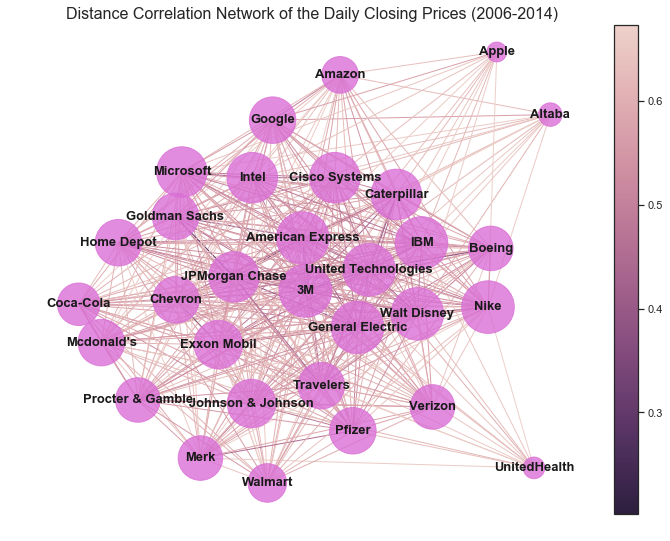

In [28]:
# plots the distance correlation network of the daily opening prices from 2006-2014
plt_corr_nx(H_close, title='Distance Correlation Network of the Daily Closing Prices (2006-2014)')

In the above visualization, the sizes of the vertices are proportional to the number of connections they have. The colorbar to the right indicates the degree of disimilarity (the distance) between the stocks. The larger the value (the lighter the color) the less similar the stocks are. Keeping this in mind, several stocks jump out. **Apple**, **Amazon**, **Altaba**, and **UnitedHealth** all lie on the periphery of the network with the fewest number of correlations above $\rho_{c} = 0.325$. On the other hand **3M**, **American Express**, **United Technolgies**, and **General Electric** sit in the core of the network with the greatest number connections above $\rho_{c} = 0.325$. It is clear from the closing prices network that our asset allocation algorithm needs to reward vertices on the periphery and punish those nearing the center. In the next code block we build a function to visualize how the edges of the distance correlation network are distributed.

## Degree Histogram

In [29]:
# function to visualize the degree distribution
def hist_plot(network, title, bins, xticks):
    
    # extracts the degrees of each vertex and stores them as a list
    deg_list = list(dict(network.degree).values())
    
    # initializes a figure
    plt.figure(figsize=(9,6))
    
    # sets the style
    plt.style.use('fivethirtyeight')
    
    # plots a pretty degree histogram with a kernel density estimator
    sns.distplot(
        deg_list,  
        kde=True,
        bins = bins,
        color='darksalmon',
        hist_kws={'alpha': 0.7}
        
    );
    
    # turns the grid off
    plt.grid(False)
    
    # controls the number and spacing of xticks and yticks
    plt.xticks(xticks, size=11)
    plt.yticks(size=11)
    
    # removes the figure spines
    sns.despine(left=True, right=True, bottom=True, top=True)
    
    # labels the y and x axis
    plt.ylabel("Probability", size=15)
    plt.xlabel("Number of Connections", size=15)
    
    # sets the title
    plt.title(title, size=20);
    
    # draws a vertical line where the mean is
    plt.axvline(sum(deg_list)/len(deg_list), 
                color='darkorchid', 
                linewidth=3, 
                linestyle='--', 
                label='Mean = {:2.0f}'.format(sum(deg_list)/len(deg_list))
    )
    
    # turns the legend on
    plt.legend(loc=0, fontsize=12)

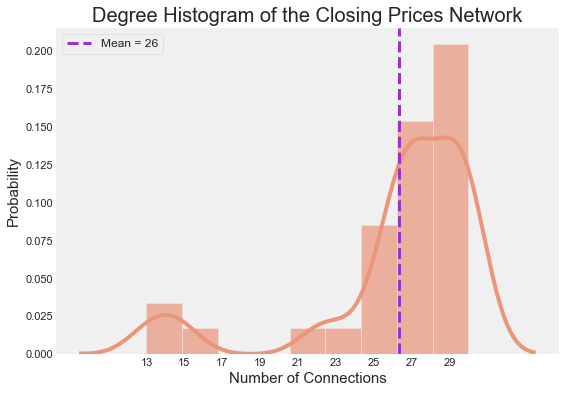

In [30]:
# plots the degree histogram of the closing prices network
hist_plot(H_close, 'Degree Histogram of the Closing Prices Network', bins=9, xticks=range(13, 30, 2))

**Observations**

* The degree distribution is left-skewed.
* The average node is connected to 86.6% of the network.
* Very few nodes are connected to less than 66.6% of the network. 
* The kernel density estimation is not a good fit.
* By eyeballing the plot, the degrees appear to follow an *inverse power-law* distribution. (This would be consistent with the findings of [Tse, *et al*. (2010)](http://cktse.eie.polyu.edu.hk/pdf-paper/JoEF-1009.pdf)).

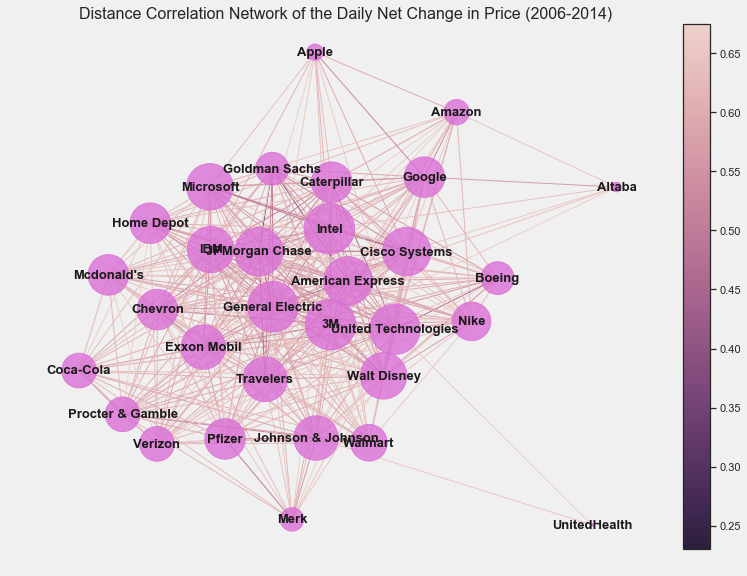

In [31]:
plt_corr_nx(H_close_diff, 
            title='Distance Correlation Network of the Daily Net Change in Price (2006-2014)'
           )

**Observations**

* The above network has substantially fewer edges than the former.
* Apple, Amazon, Altaba, UnitedHealth, and Merck have the fewest number of correlations above $\rho_{c}$.
* 3M, General Electric, American Express, Walt Disney, and United Technologies have the greatest number of correlations above $\rho_{c}$.
* UnitedHealth is clearly an outlier with only two connections above $\rho_{c}$.

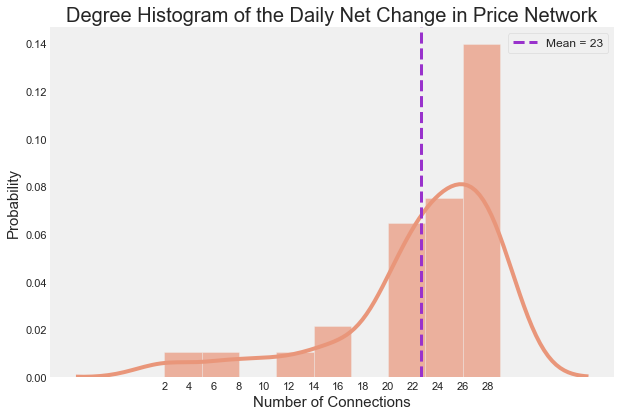

In [32]:
hist_plot(H_close_diff, 'Degree Histogram of the Daily Net Change in Price Network', 
          bins=9, 
          xticks=range(2, 30, 2)
        )

**Observations:**

* The distribution is left-skewed.
* The average node is connected to 73.3% of the network.
* Very few nodes are connected to less than 53.3% of the network.
* The kernel density estimation is a poor fit.
* The degree distribution appears to follow an inverse power-law.

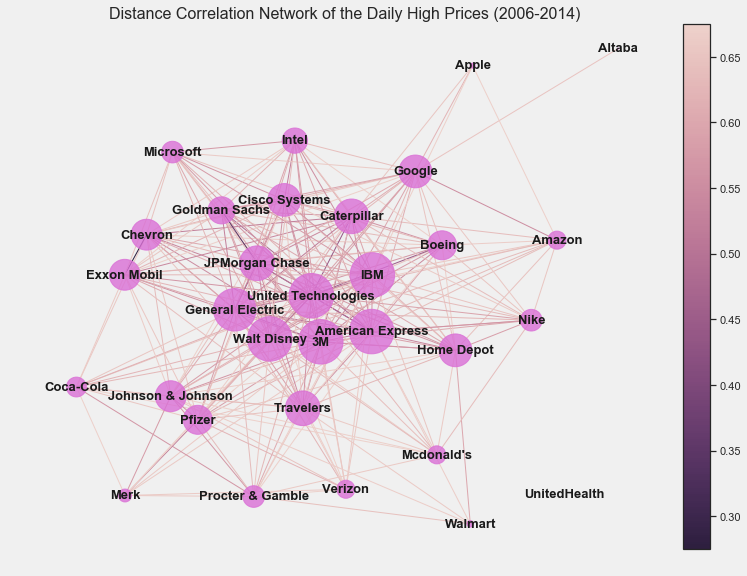

In [33]:
plt_corr_nx(H_high, title='Distance Correlation Network of the Daily High Prices (2006-2014)')

**Observations**

* The above network has substantially fewer edges than the former two.
* Apple, Altaba, Amazon, Nike, Mcdonald's, UnitedHealth, Walmart, Procter & Gamble, Verizon, and Merck all lie on the periphery with the fewest number of correlations above $\rho_{c}$.
* UnitedHealth has **no** correlations above $\rho_{c}$.
* 3M, Walt Disney, General Electric, American Express, United Technologies, and IBM sit in the core with the greatest number of correlations above $\rho_{c}$.

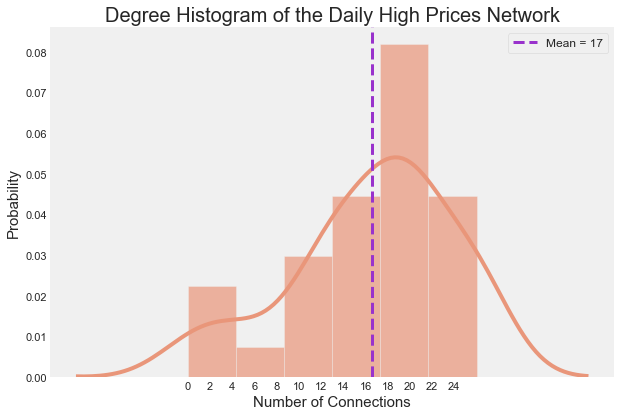

In [34]:
hist_plot(H_high, 'Degree Histogram of the Daily High Prices Network', 
          bins=6, 
          xticks=range(0,25,2)
        )

**Observations**

* In contrast to the Daily Closing and Net Change in Price networks, the Daily High network is not significantly skewed.
* The average node is connected to 53.3% of the network.
* The kernel density estimation most closely resembles a Gaussian.

The degree distribution of the daily high prices certaintly stands out. It is the only distribution that is  most resembling a Gaussian --- something you expect to see if the data is truly random. This suggests daily high prices are driven mainly by impulse buys more reflective of random dice rolling than fundamentals.

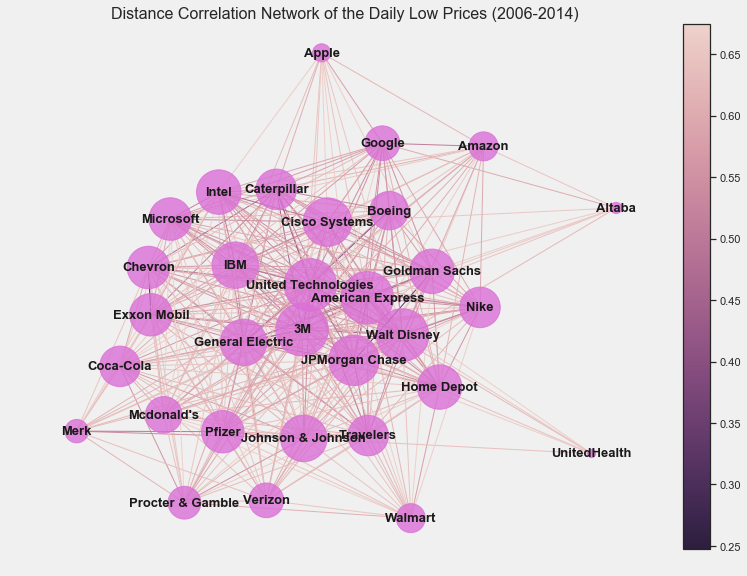

In [35]:
plt_corr_nx(H_low, title='Distance Correlation Network of the Daily Low Prices (2006-2014)')

**Observations**

* The number of edges is comparable to the Daily Closing and Net Change in Price Networks.
* Apple, Amazon, Altaba, UnitedHealth, Walmart, Procter & Gamble, Merck, and Mcdonald's have the fewest number of correlations above $\rho_{c}$.
* 3M, American Express, United Technologies, Walt Disney, JPMorgan Chase, and General Electric have the greatest number of correlations above $\rho_{c}$.
* **UnitedHealth** has the overall fewest number of correlations above $\rho_{c}$.

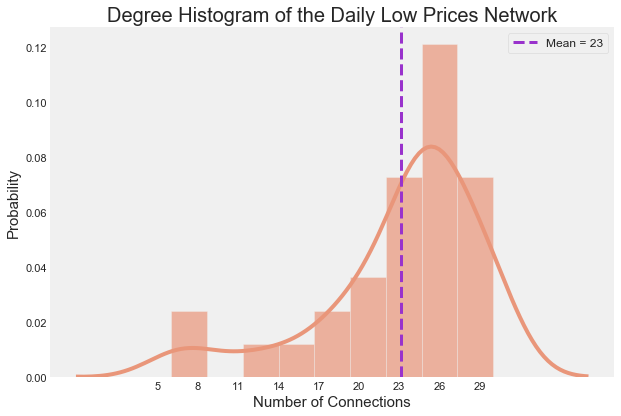

In [36]:
hist_plot(H_low, 'Degree Histogram of the Daily Low Prices Network', 
          bins=9, 
          xticks=range(5, 30, 3)
         )

**Observations**

* The degree distribution of the Daily Low Prices network is left skewed.
* The average node is connected to 73.3% of the network.
* Most nodes are connected to greater than 66.6% of the network.
* Few nodes are connected to less than 50% of the network.
* The kernel density estimator is a poor fit.

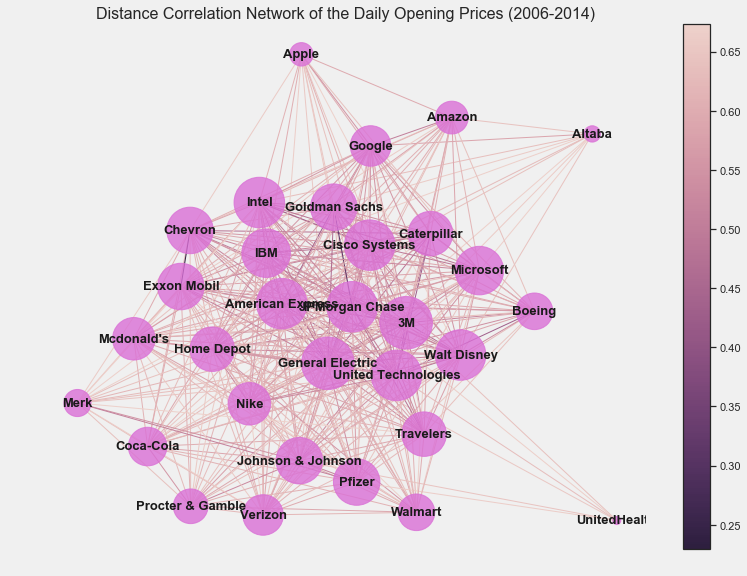

In [37]:
plt_corr_nx(H_open, title='Distance Correlation Network of the Daily Opening Prices (2006-2014)')

**Observations**

* The number of edges of the Daily Opening Prices network is comparable to the the Daily Closing Prices network.
* Apple, Amazon, Altaba, UnitedHealth, Walmart, Verizon, Procter & Gamble, and Merck have the fewest number of correlations above $\rho_{c}$.
* 3M, General Electric, United Technologies, JPMorgan Chase, and American Express have the greatest number of correlations above $\rho_{c}$.
* **Unitedhealth** has the overall fewest number of correlations above $\rho_{c}$.

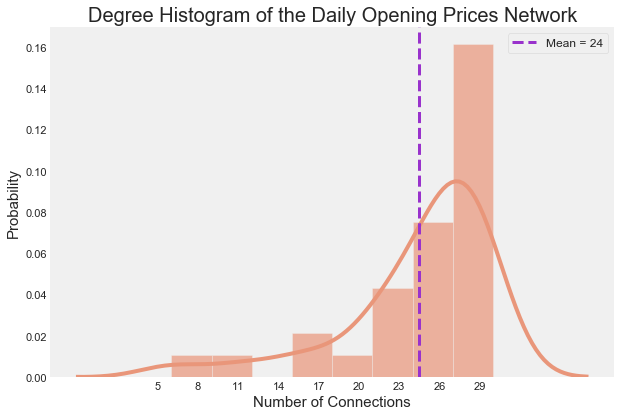

In [38]:
hist_plot(H_open, 'Degree Histogram of the Daily Opening Prices Network', 
          bins=8, 
          xticks= range(5, 30, 3)
         )

**Observations**

* The degree distribution is strongly left skewed.
* The average node is connected to 80% of the network.
* Few nodes are connected to less than 50% of the network.
* The kernel density estimation provides a poor fit.
* The degree distribution appears to follow an inverse power-law.

# The Hedgecrafted Portfolio

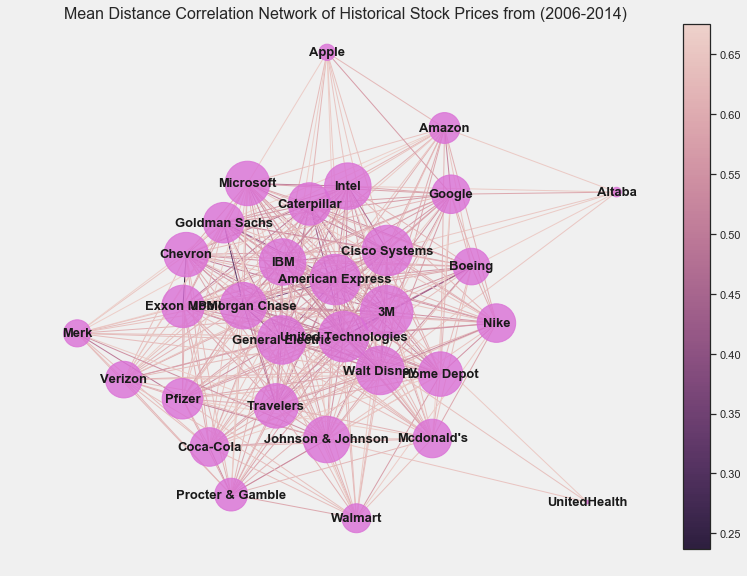

In [39]:
# initializes a DataFrame full of zeros
df_zeros = pd.DataFrame(index=stocks, columns=stocks).fillna(0)

# iterates over the length of the DataFrame list containg the Open, High, Low, Close, and Close_diff
# time series
for i in range(len(df_train_list)):
    
    # Adds the distance correlation DataFrames of the Open, High, Low, Close, and Close_diff
    # time series together
    df_zeros += df_train_dcor_list[i]
    
    # Takes the average of the distance correlation DataFrames
    df_master = df_zeros/len(df_train_list)

# Builds the master network with the averaged distance correlation DataFrame
H_master = build_corr_nx(df_master)

# Plots the master network
plt_corr_nx(H_master, 
            title='Mean Distance Correlation Network of Historical Stock Prices from (2006-2014)'
           )

**Observations**

* Apple, Amazon, Altaba, UnitedHealth, Walmart, Procter & Gamble, and Merck have the fewest number of correlations above $\rho_{c}$.
* General Electric, American Express, 3M, United Technologies, and Walt Disney have the greatest number of correlations above $\rho_{c}$.
* **UnitedHealth** is the *least* correlated stock in our portfolio, followed by **Altaba** and **Apple**.
* **3M** is the *most* correlated, followed by **United Technologies** and **American Express**.

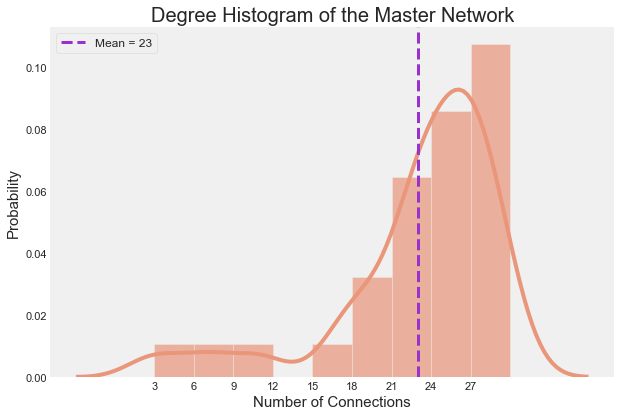

In [40]:
hist_plot(H_master, 'Degree Histogram of the Master Network', 
          bins=9, 
          xticks=range(3, 30, 3)
         )

**Observations**

* The degree distribution is left skewed.
* The average node is connected to 76.6% of the network.
* Most nodes are connected to 66.6% of the network.
* Few nodes are connected to less than 50% of the network.
* The kernel density estimation is a poor fit.
* The degree distribution appears to follow an inverse power-law.

# Communicability as a Measure of Relative Risk

We are now in a position to devise a method to compute the allocation weights of our portfolio. To recall, this is the problem:

**Given the $N$ assets in our portfolio, find a way of computing the allocation weights $w_{i}$, &thinsp; $\Big( \sum_{i=1}^{N}w_{i}=1\Big)$ such that assets more correlated with each other obtain lower weights while those less correlated with each other obtain higher weights.**

Theres an infinite number of possible solutions to the above problem. The asset correlation network we built contains information on how our portfolio is interrelated (whose connected to who), but it does not tell us how each asset *impacts* the other or how those impacts travel throughout the network. If, for example, Apple's stock lost 40% of its value wiping out, say, five years of gains, how would this impact the remaining assets in our portfolio? How easily does this kind of behaviour spread and how can we keep our capital isolated from it? We thus seek a measure of "relative risk" that quantifies not only the correlations between assets, but how those correlations mediate perturbations in the portfolio. Our aim, therefore, is twofold: allocate capital inversely proportional to (1) the correlations between assets and (2) proportional to the "impact resistence" of each asset. As luck would have it, there is a [centrality](https://en.wikipedia.org/wiki/Centrality) measure that does just this! Let us define the relative risk as follows:

<br/><br/>
<center>$\text{Relative Risk of Asset} \ r$ = $\dfrac{\omega_{r}}{\sum_{r'=1}^{N}\omega_{r'}}$,</center>
<br/><br/>
where 
<center>$\omega_{r} = \dfrac{1}{C}\sum_{p}\sum_{q}\dfrac{G_{prq}}{G_{pq}}$</center>

is the **Communicability Betweenness centrality** [(Estrada, *et al.* (2009))](https://arxiv.org/pdf/0905.4102.pdf) of node $r$. Here
<br/><br/>
<center>$G_{prq} = \big(\exp{\textbf{A}}\big)_{pq} - \big(\exp{(\textbf{A} - \textbf{E}(r))}\big)_{pq}$</center>

is the number of weighted [walks](http://mathworld.wolfram.com/Walk.html) involving only node $r$,
<br/><br/>
<center>$G_{pq} = \big(\exp{\textbf{A}}\big)_{pq}$</center>

is the so-called *communicability* between nodes $p$ and $q$,
<br/><br/>
<center>$A_{pq} = \begin{cases} 
      1, & \text{if} \ \rho \geq \rho_{c}  \\
      0, & \text{otherwise}
   \end{cases}$</center>
   
is the adjacency matrix induced by the distance correlation matrix $\text{Cor}_{ij}$, and $\textbf{E}(r)$ is a matrix such that when added to $\textbf{A}$, yields a new graph $G(r) = (V, E')$ with all edges connecting $r \in V$ removed. The constant $C = (n-1)^2 - (n-1)$ normalizes $\omega_{r}$ such that it takes values between 0 and 1. We can better understand what $\omega_{r}$ is counting by re-writing the matrix exponential as a taylor series:
<br/><br/>

<center>$\exp{\textbf{A} = \sum_{k=1}^{\infty}}\dfrac{\textbf{A}^{k}}{k!}$</center>

Rasing the adjacency matrix to the power of $k$ counts all walks from $p$ to $q$ of length $k$. The matrix exponential therefore counts all possible ways of moving from $p$ to $q$ weighted by the inverse factorial of $k$. So the denominator of $\omega_{r}$ counts all weighted walks involving every node. Put simply,
<br/><br/>

<center>$\boxed{\text{Communicability Betweenees centrality} = \dfrac{\text{sum of all weighted walks involving node r}}{\text{sum of all weighted walks involving every node}}}$</center>

So the communicability betweenness centrality is proportional to the number of connections (correlations) a node has and therefore satisifies the first requirement of relative risk. Next, we explore how this measure quantifies the spread of impacts throughout the network, satisfying our second requirement.

## The Physics of what Communicability Measures

[Estrada & Hatano (2007)](https://arxiv.org/pdf/0707.0756.pdf) provided an ingenius argument showing the communicability of a network is identical to the Green's function of a network. That is, it measures how impacts (or more generally thermal fluctuations) travel from one node to another. Their argument works by treating each node as an oscillator and each edge as a spring (which is what we did to generate the visualization of our asset correlation network). Intuitively, we can draw an analogy between the movement of an asset's price and its motion in a ball-spring system. In this analogy, volatility is equivalent to how energetic the oscillator is. Revisiting the hypothetical scenerio of Apple losing 40% of its value: we can visualize this in our mind's eye as an impact to one of the masses---causing it to violently oscillate. How does this motion propagate throughout the rest of the ball-spring system? Which masses absorb the blow and which reflect it? Communicability betweeness centrality answers this question by counting all possible ways the impact can reach node $r$. Higher values indicate the node has a greater susceptiblility to impacts whereas lower values denote just the opposite.

# The Bottom Line

The communicability of a network quantifies how impacts spread from one node to another. In the context of an asset correlation network, communicability measures how volatility travels node to node. **We aim to position our capital such that it's the most resistant to the communicability of volatility**. Recall we seek a portfolio that (1) consistently generates wealth while minimizing potential losess and (2) is robust against large market fluctuations and economic downturns. Of course, generous returns are desired, but not in a way that threatens our initial investment. To this end, the strategy moving forward is this: allocate capital inversely proportional to its relative (or intraportfolio) risk.


## Intraportfolio Risk

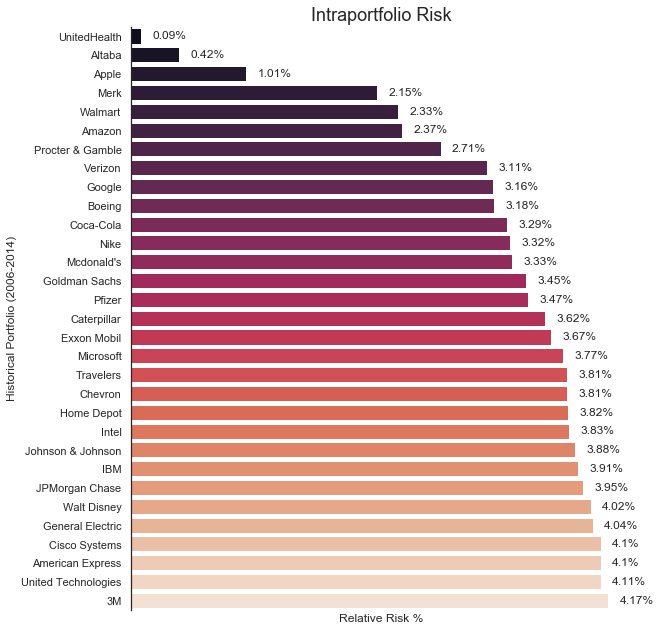

In [83]:
# calculates the communicability betweeness centrality and returns a dictionary
risk_alloc = nx.communicability_betweenness_centrality(H_master)

# converts the dictionary of degree centralities to a pandas series
risk_alloc = pd.Series(risk_alloc)

# normalizes the degree centrality 
risk_alloc = risk_alloc / risk_alloc.sum()

# resets the index
risk_alloc.reset_index()

# converts series to a sorted DataFrame
risk_alloc = (
        pd.DataFrame({"Stocks": risk_alloc.index, "Risk Allocation": risk_alloc.values})
        .sort_values(by="Risk Allocation", ascending=True)
        .reset_index()
        .drop("index", axis=1)
    )

# initializes figure
plt.figure(figsize=(8,10))

# sets seaborn style
sns.set(style='white')

# plots a pretty seaborn barplot
sns.barplot(x='Risk Allocation', y='Stocks', data=risk_alloc, palette="rocket")

# removes spines
sns.despine(right=True, top=True, bottom=True)

# turns xticks off
plt.xticks([])

# labels the x axis
plt.xlabel("Relative Risk %", size=12)

# labels the y axis
plt.ylabel("Historical Portfolio (2006-2014)", size=12)

# figure title
plt.title("Intraportfolio Risk", size=18)

# iterates over the stocks (label) and their numerical index (i)
for i, label in enumerate(list(risk_alloc.index)):
    
    # gets the height of each bar in the barplot
    height = risk_alloc.loc[label, 'Risk Allocation']
    
    # gets the relative risk as a percentage (the labels)
    label = (risk_alloc.loc[label, 'Risk Allocation']*100 
                ).round(2).astype(str) + '%'
    
    # annotates the barplot with the relative risk percentages
    plt.annotate(str(label), (height + 0.001, i + 0.15))

We read an intraportfolio risk plot like this: Altaba is $\dfrac{0.47}{0.09} = 4.66$ times riskier than UnitedHealth (UNH), Apple is $\dfrac{1.01}{0.09} = 11.22$ times more risky than UNH, ... , and 3M is a whopping $\dfrac{4.17}{0.09} = 46.33$ times riskier than UNH! Conversely, 3M is $\dfrac{4.17}{4.11} = 1.01$ times as risky as United Technologies, $\dfrac{4.17}{4.11} = 1.01$ times as risky as American Express, so on and so forth. Intuitively, the assets that cluster in the center of the network are most susceptible to impacts, whereas those further from the cluster are the least susceptible. The logic from here is straightforward: take the inverse of the relative risk (which we call the "relative certainty") and normalize it such that it adds to 1. These are the asset weights. Formally,
<br/><br/>
<center>$\text{Relative Certainty of Asset} \ r = \dfrac{1}{\omega_{r} \sum_{r'}\omega_{r'}^{-1}}$</center>

Next, Let's visualize the allocation of 10,000 (USD) in our portfolio.

## Communicability-Based Asset Allocation

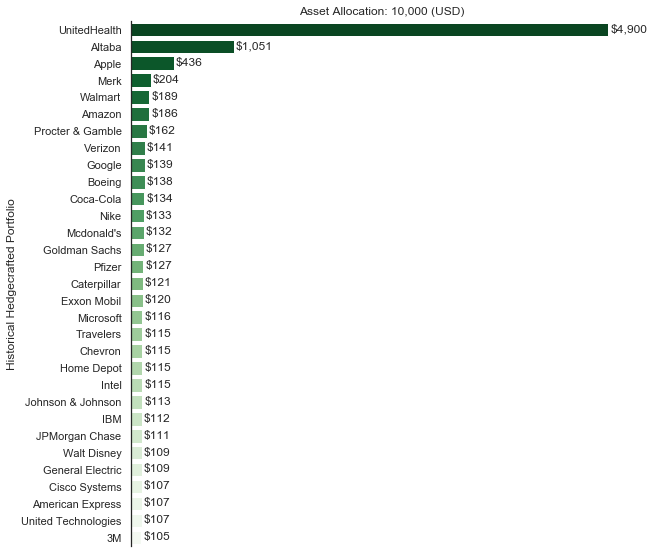

In [42]:
# calculates degree centrality and assigns it to investmnet_A
investment_A = nx.communicability_betweenness_centrality(H_master)

# calculates the inverse of the above and re-asigns it to investment_A as a pandas series
investment_A = 1 / pd.Series(investment_A)

# normalizes the above
investment_A = investment_A / investment_A.sum()

# resets the index
investment_A.reset_index()

# converts the above series to a sorted DataFrame
investment_A = (
        pd.DataFrame({"Stocks": investment_A.index, "Asset Allocation": investment_A.values})
        .sort_values(by="Asset Allocation", ascending=False)
        .reset_index()
        .drop("index", axis=1)
    )

# initializes a figure
plt.figure(figsize=(8,9))

# sets seaborn plot style
sns.set(style='white')

# plot a pretty seaborn barplot
sns.barplot(x='Asset Allocation', y='Stocks', data=investment_A, palette="Greens_r")

# despines the figure
sns.despine(right=True, top=True, bottom=True)

# turns xticks off
plt.xticks([])

# turns the x axis label off
plt.xlabel('')

# fig title
plt.title("Asset Allocation: 10,000 (USD)", size=12)

# y axis label
plt.ylabel("Historical Hedgecrafted Portfolio", size=12)

# captial to be allocated
capital = 10000

# iterates over the stocks (label) and their numerical indices (i)
for i, label in enumerate(list(investment_A.index)):
    
    # gets the height of each bar
    height = investment_A.loc[label, 'Asset Allocation']
    
    # calculates the capital to be allocated
    label = (investment_A.loc[label, 'Asset Allocation'] * capital
                ).round(2)
    
    # annotes the capital above each bar
    plt.annotate('${:,.0f}'.format(label), (height + 0.002, i + 0.15))

UnitedHealth recieves nearly 50%, Altaba gets about 10%, Apple 4%, Merck 2%, and the remaining assets recieve less than 2% of our capital. To the traditional invester, this strategy may appear "risky" since 60% of our investment is with 2 of our 31 assets. While it's true *if* UnitedHealth is hit hard we'll lose a substantial amount of money, our algorithm predicts UnitedHealth is the *least* likey to take a hit if and when our other assets get in trouble. UnitedHealth is clearly the winning pick in our portfolio.

It's worth pointing out that the methods we've used to generate the asset allocation weights differ dramatically from the contemporary methods of MPT and its extensions. The approach taken in this project makes no assumptions of future outcomes of a portfolio, i.e., the algorithm doesn't require us to make a prediction of the expected returns (as MPT does). What's more---we're not solving an optimization problem---there's nothing to be minimized or maximized. Instead, we observe the topology (interrelatedness) of our portfolio, predict which assets are the most susceptible to the communicability of volatile behaviour and allocate capital accordingly.

In [43]:
# DataFrame of the prices we buy stock at
df_buy_in = df_train_close_copy.loc['2014-12-31'].sort_index().to_frame('Buy In: 2014-12-31')

## Modified Allocation Strategy: Allocate Capital in the Maximum Independent Set

The maximum independent set (MIS) is the largest set of vertices such that no two are adjacent. Applied to our asset correlation network, the MIS is the greatest number of assets such that every pair has a correlation below $\rho_{c} = 0.325$. The size of the MIS is inversely proportional to the threshold $\rho_{c}$, i.e., it is by definition a minimally correlated portfolio. Larger values of $\rho_{c}$ produce a sparse network (more edges are removed) and therefore the MIS tends to be larger. An optimized portfolio would therefore correspond to maximizing the size of the MIS subject to minimizing $\rho_{c}$. The best way to do this is to increase the universe of assets we're willing to invest in. By further diversifying the portfolio with many asset types and classes, we can isolate the largest number of minimally correlated assets and allocate capital inversely proportional to their relative risk. While generating the asset weights remains a non-optimization problem, generating the asset correlation network *becomes* one. We're really solving two sepreate problems: determing how to build the asset correlation network (there are many) and determining which graph invariants (there are many) to extract the asset weights from the network. As such, one can easily imagine a vast landscape of portfolios beyond that of MPT and a metric fuck-tonne of wealth to create.

In [44]:
# imports the approximation submodule from Networkx
from networkx.algorithms import approximation

# returns the approximate maximum independent set (MIS) of H_master
max_ind_set = approximation.maximum_independent_set(H_master)
print(max_ind_set)

{'Merk', 'Walmart', 'UnitedHealth', 'Altaba', 'Apple', 'Boeing'}


In [45]:
df_mis_buy_in = df_buy_in.loc[list(max_ind_set)]
df_mis_buy_in

,Buy In: 2014-12-31
Name,
Merk,56.79
Walmart,85.88
UnitedHealth,101.09
Altaba,50.51
Apple,110.38
Boeing,129.98


# Backtesting with Modern Portfolio Theory

Now that we have a viable alternative to portfolio optimization, it's time to see how the Hedgecraft portfolio performed in the validation years (15', 16', and 17') with respect to the Markowitz portfolio (i.e., [efficient frontier](https://www.investopedia.com/video/play/explaining-efficient-frontier/) model) and the overall market. To summarize our workflow thus far we:

1. Preprocessed historical pricing data of 31 stocks from 2006-2014 for time series analyses.
2. Computed the *distance correlation matrix* $\rho_{D}(X_{i}, X_{j})$ for the ``Open``, ``High``, ``Low``, ``Close``, and ``Close_diff`` with the dcor package.
3. Used the NetworkX module to transform each distance correlation matrix into a weighted graph.
4. Adopted the winner-take-all method by Tse, *et al.* and removed edges with correlations below a threshold value of $\rho_{c} = 0.325$.
5. Inspected the degree histograms for each network. 
6. Built a master network by averaging over the edge weights of the ``Open``, ``High``, ``Low``, ``Close``, and ``Close_diff`` networks.
7. Defined the relative risk of each asset as the communicabality betweeness centrality of the master network.
8. Defined the asset weights as the normalized inverse of communicability betweeness centrality.


In [46]:
###############################################
# Hedgecraft weights
###############################################

# calculates degree centrality
weights = nx.communicability_betweenness_centrality(H_master)

# dictionary comprehension of communicability centrality for the maximum independent set
mis_weights = {key: weights[key] for key in list(max_ind_set)}

# iterates over the key, value pairs in the weights dict
for key, value in weights.items():
    
    # takes the inverse of the degree centrality of each asset
    weights[key] = 1/value
    
# normalization parameter
norm = 1.0 / sum(weights.values())

# iterates over the keys (stocks) in the weights dict
for key in weights:
    
    # updates each value to the normalized value
    weights[key] = round(weights[key] * norm, 3)

################################################
# Hedgecraft MIS weights
################################################

for key, value in mis_weights.items():
    mis_weights[key] = 1/value
    
mis_norm = 1.0 / sum(mis_weights.values())

for key in mis_weights:
    mis_weights[key] = round(mis_weights[key] * mis_norm, 3)

print(weights)
print('\n')
print(mis_weights)

{'3M': 0.011, 'Altaba': 0.105, 'Amazon': 0.019, 'American Express': 0.011, 'Apple': 0.044, 'Boeing': 0.014, 'Caterpillar': 0.012, 'Chevron': 0.012, 'Cisco Systems': 0.011, 'Coca-Cola': 0.013, 'Exxon Mobil': 0.012, 'General Electric': 0.011, 'Goldman Sachs': 0.013, 'Google': 0.014, 'Home Depot': 0.012, 'IBM': 0.011, 'Intel': 0.011, 'JPMorgan Chase': 0.011, 'Johnson & Johnson': 0.011, "Mcdonald's": 0.013, 'Merk': 0.02, 'Microsoft': 0.012, 'Nike': 0.013, 'Pfizer': 0.013, 'Procter & Gamble': 0.016, 'Travelers': 0.012, 'United Technologies': 0.011, 'UnitedHealth': 0.49, 'Verizon': 0.014, 'Walmart': 0.019, 'Walt Disney': 0.011}


{'Merk': 0.03, 'Walmart': 0.027, 'UnitedHealth': 0.708, 'Altaba': 0.152, 'Apple': 0.063, 'Boeing': 0.02}


In [47]:
# imports a tool to convert capital into shares
from pypfopt import discrete_allocation

# returns the number of shares to buy given the asset weights, prices, and capital to invest
alloc = discrete_allocation.portfolio(weights, 
                                      df_buy_in['Buy In: 2014-12-31'], 
                                      total_portfolio_value=capital
                                     )
# returns same as above but for the MIS
mis_alloc = discrete_allocation.portfolio(mis_weights, df_mis_buy_in['Buy In: 2014-12-31'],
                                         total_portfolio_value=capital
                                        )

0 out of 31 tickers were removed
Funds remaining: 10.10
0 out of 6 tickers were removed
Funds remaining: 17.76


In [48]:
# converts above shares to a pandas series
alloc_series = pd.Series(alloc[0], name='Shares')

# names the series
alloc_series.index.name = 'Assets'

# resets index, prints assets and the shares we buy
alloc_series.reset_index
print(alloc_series)

print('\n')

# does same as above but for the MIS
mis_alloc_series = pd.Series(mis_alloc[0], name='MIS Shares')
mis_alloc_series.index.name = 'Assets'
mis_alloc_series.reset_index
print(mis_alloc_series)

Assets
UnitedHealth           48
Altaba                 20
Apple                   3
Merk                    3
Amazon                  1
Walmart                 2
Procter & Gamble        2
Boeing                  1
Google                  1
Verizon                 2
Coca-Cola               3
Goldman Sachs           1
Mcdonald's              1
Nike                    2
Pfizer                  4
Caterpillar             1
Chevron                 1
Exxon Mobil             1
Home Depot              1
Microsoft               2
Travelers               1
3M                      1
American Express        1
Cisco Systems           3
General Electric        4
IBM                     1
Intel                   3
JPMorgan Chase          1
Johnson & Johnson       1
United Technologies     0
Walt Disney             1
Name: Shares, dtype: int64


Assets
UnitedHealth    70
Altaba          30
Apple            6
Merk             6
Walmart          3
Boeing           1
Name: MIS Shares, dtype: int64


In [49]:
# converts shares series to a DataFrame
df_alloc = alloc_series.sort_index().to_frame('Shares')
df_mis_alloc = mis_alloc_series.sort_index().to_frame('MIS Shares')

In [50]:
################################################################
# EF model
################################################################

# imports a tool to calculate the mean historical return from a 
# portfolio optimization package called pypfopt
from pypfopt.expected_returns import mean_historical_return

# returns the mean historical return of the training data
mu = mean_historical_return(df_train_close_copy)

# computes the covariance matrix
S = df_train_close_copy.cov()

In [51]:
################################################################
# EF model weights
################################################################

# imports the efficient frontier model for asset allocation
from pypfopt.efficient_frontier import EfficientFrontier

# runs the efficient frontier (EF) algo
ef = EfficientFrontier(mu, S)

# computes portfolio weights subject to minimizing the volatility (portfolio std)
weights_ef = ef.min_volatility()

# rounds and prints the weights
cleaned_weights = ef.clean_weights()
print(cleaned_weights)

{'3M': 0.0, 'Altaba': 0.0, 'Amazon': 0.0, 'American Express': 0.0, 'Apple': 0.0, 'Boeing': 0.0, 'Caterpillar': 0.0, 'Chevron': 0.0, 'Cisco Systems': 0.62264, 'Coca-Cola': 0.13036, 'Exxon Mobil': 0.0, 'General Electric': 0.0, 'Goldman Sachs': 0.0, 'Google': 0.0, 'Home Depot': 0.0, 'IBM': 0.0, 'Intel': 0.17268, 'JPMorgan Chase': 0.0, 'Johnson & Johnson': 0.0, "Mcdonald's": 0.0, 'Merk': 0.0, 'Microsoft': 0.0, 'Nike': 0.0, 'Pfizer': 0.07431, 'Procter & Gamble': 0.0, 'Travelers': 0.0, 'United Technologies': 0.0, 'UnitedHealth': 0.0, 'Verizon': 0.0, 'Walmart': 0.0, 'Walt Disney': 0.0}


In [52]:
################################################################
# EF model asset allocation
################################################################

# returns the number of shares to buy given asset prices, weights, and capital to invest for the EF model
ef_alloc = discrete_allocation.portfolio(weights_ef,
                                      df_buy_in['Buy In: 2014-12-31'], 
                                      total_portfolio_value=capital
                                     )

27 out of 31 tickers were removed
Funds remaining: 6.27


In [53]:
################################################################
# EF model shares
################################################################

# converts EF shares to a pandas series
ef_alloc_series = pd.Series(ef_alloc[0], name='Shares')

# names the series
ef_alloc_series.index.name = 'Assets'

# resets index, prints assets and the shares we buy
ef_alloc_series.reset_index

<bound method Series.reset_index of Assets
Cisco Systems    224
Intel             47
Coca-Cola         31
Pfizer            24
Name: Shares, dtype: int64>

In [54]:
# converts EF shares series to a DataFrame
df_ef_alloc = ef_alloc_series.sort_index().to_frame('Shares')

In [90]:
# total capital invested in each model after buying shares
df_capital = (df_buy_in['Buy In: 2014-12-31']*df_alloc['Shares']).sum()
df_ef_capital = (df_buy_in['Buy In: 2014-12-31']*df_ef_alloc['Shares']).sum()
df_mis_capital = (df_mis_buy_in['Buy In: 2014-12-31']*df_mis_alloc['MIS Shares']).sum()

######################################################################
# Hedgecraft model performance
######################################################################

# multiplies the shares of the hedgecraft model with the closing prices for each stock
# and appends it to the daily return on investment (daily_roi) list of DataFrames
daily_roi = []
for stock in df_alloc.index:
    daily_roi.append(df_alloc.loc[stock].values * df_validate[stock])
    
# takes the daily_roi list of DataFrames concatenating it into a single DataFrame and
# adds the return on investment for each asset, returning the total daily return on investment
daily_roi_df = pd.concat(daily_roi, axis=1).reset_index()
daily_roi_df.set_index("Date", inplace=True)
total_daily_roi = daily_roi_df.sum(axis=1)

# converts the daily roi to a percentage format, renames the Dataframe
daily_roi_rate = total_daily_roi.apply(lambda returns: ((returns - df_capital) / df_capital)*100)
daily_roi_rate = daily_roi_rate.rename('Hedgecraft Daily Returns')

#######################################################################
# EF model performance
#######################################################################

# same as above but for EF model
ef_daily_roi=[]
for stock in df_ef_alloc.index:
    ef_daily_roi.append(df_ef_alloc.loc[stock].values * df_validate[stock])
    
ef_daily_roi_df = pd.concat(ef_daily_roi, axis=1).reset_index()
ef_daily_roi_df.set_index("Date", inplace=True)
ef_total_daily_roi = ef_daily_roi_df.sum(axis=1)


ef_daily_roi_rate = ef_total_daily_roi.apply(lambda returns: ((returns - df_ef_capital) / df_ef_capital)*100)
ef_daily_roi_rate = ef_daily_roi_rate.rename('EF Daily Returns')

######################################################################
# Hedgecraft MIS model performance
######################################################################

# same as above but for the MIS model
mis_daily_roi = []
for stock in df_mis_alloc.index:
    mis_daily_roi.append(df_mis_alloc.loc[stock].values * df_validate[stock])
    
mis_daily_roi_df = pd.concat(mis_daily_roi, axis=1).reset_index()
mis_daily_roi_df.set_index("Date", inplace=True)
mis_total_daily_roi = mis_daily_roi_df.sum(axis=1)

mis_daily_roi_rate = mis_total_daily_roi.apply(lambda returns: ((returns - df_mis_capital) / df_mis_capital)*100)
mis_daily_roi_rate = mis_daily_roi_rate.rename('MIS Daily Returns')


In [56]:
# imports mean statistics from scipy
from scipy.stats import mstats

###################################################################################
# Hedgecraft model stats
###################################################################################

# end of year returns for the hedgecraft model
returns_2015 = daily_roi_rate['2015-12-31']
returns_2016 = daily_roi_rate['2016-12-29']
returns_2017 = daily_roi_rate['2017-12-29']

# dictionary of end of year returns
returns_dict = {'2015': returns_2015 , '2016': returns_2016, '2017': returns_2017}

# pct of capital gains from 15' to 16'
returns_16_15_diff = returns_2016 - returns_2015

# pct of capital gains from 16' to 17'
returns_17_16_diff = returns_2017 - returns_2016

#calculates the geometric mean of the annual return rates
gmean_returns = ((mstats.gmean([1 + returns_2015/100, 
                              1 + returns_16_15_diff/100,
                              1 + returns_17_16_diff/100])) - 1)*100

# computes daily change in returns from 2015-2017
stock_daily_ret = df_validate.pct_change()

# computes the covariance matrix of the above
cov_matrix = stock_daily_ret.cov()

# initializes weights
weights_list = []

# iterates over weights dict and appends above list
for key, value in weights.items():
    weights_list.append(value)

# converts weights list to numpy array
weights_arr = np.array(weights_list)

# calculates the annualized portfolio standard deviation from 2015-2017 in pct format
portfolio_std_dev = np.sqrt(np.dot(weights_arr.T, np.dot(cov_matrix, weights_arr)))*np.sqrt(252)*100

# calculates the Sharpe ratio
## The 10-year treasurey rate at the time of investment (~2%) is used as the risk-free rate
sharpe_ratio = (gmean_returns - 2) / portfolio_std_dev

# list of yearly returns rounded and in pct format
yearly_returns = list(returns_dict.values())
yearly_returns = [str(round(x, 1)) + '%' for x in yearly_returns]

# list of yearly return rates rounded and in pct format
yearly_return_rates = [returns_2015, returns_16_15_diff, returns_17_16_diff]
yearly_return_rates = [str(round(x, 1)) + '%' for x in yearly_return_rates]

# list of summary statistics rounded and in pct format
summary_stats = [gmean_returns, portfolio_std_dev] 
summary_stats = [str(round(x, 1)) + '%' for x in summary_stats]
summary_stats.append(round(sharpe_ratio, 2))

In [57]:
##############################################################################
# EF model stats
##############################################################################

# end of year returns for the efficient frontier model
ef_returns_2015 = ef_daily_roi_rate['2015-12-31']
ef_returns_2016 = ef_daily_roi_rate['2016-12-29']
ef_returns_2017 = ef_daily_roi_rate['2017-12-29']

# dictionary of end of year returns
ef_returns_dict = {'2015': ef_returns_2015, '2016': ef_returns_2016, '2017':ef_returns_2017}

# pct of capital gains from 15' to 16'
ef_returns_16_15_diff = ef_returns_2016 - ef_returns_2015

# pct of capital gains from 16' to 17'
ef_returns_17_16_diff = ef_returns_2017 - ef_returns_2016

# calculates the geometric mean of the annual return rates
ef_gmean_returns = (((mstats.gmean([1+ ef_returns_2015/100, 
                          1+ ef_returns_16_15_diff/100, 
                          1+ ef_returns_17_16_diff/100]) - 1))*100)

# initializes weights list
weights_ef_list = []

# iterates over weights dict and appends above list
for key, value in weights_ef.items():
    weights_ef_list.append(value)

# converts weights list to numpy array
weights_ef_arr = np.array(weights_ef_list)

# calculates portfolio standard deviation from 2015-2017
ef_portfolio_std_dev = np.sqrt(np.dot(weights_ef_arr.T, np.dot(cov_matrix, weights_ef_arr))
                               )*np.sqrt(252)*100

# calculates sharpe ratio
## The 10-year treasurey rate at the time of investment (~2%) is used as the risk-free rate
ef_sharpe_ratio = (ef_gmean_returns - 2)/ ef_portfolio_std_dev

# list of yearly returns rounded and in pct format
ef_yearly_returns = list(ef_returns_dict.values())
ef_yearly_returns = [str(round(x, 1)) + '%' for x in ef_yearly_returns]

# list of yearly return rates rounded and in pct format
ef_yearly_return_rates = [ef_returns_2015, ef_returns_16_15_diff, ef_returns_17_16_diff]
ef_yearly_return_rates = [str(round(x, 1)) + '%' for x in ef_yearly_return_rates]

# list of summary statsitics rounded and in pct format
ef_summary_stats = [ef_gmean_returns, ef_portfolio_std_dev]
ef_summary_stats = [str(round(x, 1)) + '%' for x in ef_summary_stats]
ef_summary_stats.append(round(ef_sharpe_ratio, 2))

In [58]:
##############################################################################
# Hedgecraft MIS model stats
##############################################################################

# end of year return rates
mis_returns_2015 = mis_daily_roi_rate['2015-12-31']
mis_returns_2016 = mis_daily_roi_rate['2016-12-29']
mis_returns_2017 = mis_daily_roi_rate['2017-12-29']

# dictionary of end of year returns
mis_returns_dict = {'2015': mis_returns_2015, '2016': mis_returns_2016, '2017':mis_returns_2017}

# pct of capital gains from 15' to 16'
mis_returns_16_15_diff = mis_returns_2016 - mis_returns_2015

# pct of capital gains from 16' to 17'
mis_returns_17_16_diff = mis_returns_2017 - mis_returns_2016

# calculates the geometric mean of the annual return rates
mis_gmean_returns = (((mstats.gmean([1+ mis_returns_2015/100, 
                          1+ mis_returns_16_15_diff/100, 
                          1+ mis_returns_17_16_diff/100]) - 1))*100)

# computes daily change in returns from 2015-2017
mis_stock_daily_ret = df_validate[list(max_ind_set)].pct_change()

# computes the covariance matrix
mis_cov_matrix = mis_stock_daily_ret.cov()

# initializes weights list
mis_weights_list = []

# iterates over weights dict and appends above list
for key, value in mis_weights.items():
    mis_weights_list.append(value)

# converts weights list to numpy array
mis_weights_arr = np.array(mis_weights_list)

# calculates portfolio standard deviation from 2015-2017
mis_portfolio_std_dev = np.sqrt(np.dot(mis_weights_arr.T, np.dot(mis_cov_matrix, mis_weights_arr))
                               )*np.sqrt(252)*100

# calculates sharpe ratio
## The 10-year treasurey rate at the time of investment (~2%) is used as the risk-free rate
mis_sharpe_ratio = (mis_gmean_returns - 2)/ mis_portfolio_std_dev

# list of yearly returns rounded and in pct format
mis_yearly_returns = list(mis_returns_dict.values())
mis_yearly_returns = [str(round(x, 1)) + '%' for x in mis_yearly_returns]

# list of yearly return rates rounded and in pct format
mis_yearly_return_rates = [mis_returns_2015, mis_returns_16_15_diff, mis_returns_17_16_diff]
mis_yearly_return_rates = [str(round(x, 1)) + '%' for x in mis_yearly_return_rates]

# list of summary statistics rounded and in pct format
mis_summary_stats = [mis_gmean_returns, mis_portfolio_std_dev]
mis_summary_stats = [str(round(x, 1)) + '%' for x in mis_summary_stats]
mis_summary_stats.append(round(mis_sharpe_ratio, 2))

In [59]:
# dictionary summary of model performances
backtest_summary = {'Hedgecraft Returns': yearly_returns,
                    'Hedgecraft MIS Returns': mis_yearly_returns,
                    'Efficient Frontier Returns': ef_yearly_returns,
                   'Hedgecraft Return Rates': yearly_return_rates,
                    'Hedgecraft MIS Return Rates': mis_yearly_return_rates, 
                   'Efficient Frontier Return Rates': ef_yearly_return_rates,
                    
                   }

# converts above dict to a DataFrame
backtest_summary = pd.DataFrame.from_dict(backtest_summary)
backtest_summary = backtest_summary.rename(index={0:'2015', 1:'2016', 2:'2017'});

# dictionary of stats
backtest_stats = {'Hedgecraft': summary_stats, 
                  'Hedgecraft MIS': mis_summary_stats, 
                  'Efficient Frontier': ef_summary_stats
                 }

# converts above dict to DataFrame
backtest_stats =  pd.DataFrame.from_dict(backtest_stats)
backtest_stats = backtest_stats.rename(index={0:'Avg Annual Rate of Returns', 
                             1:'Annual Volatility', 
                             2:'Annualized Sharpe Ratio'
                            }
                     );

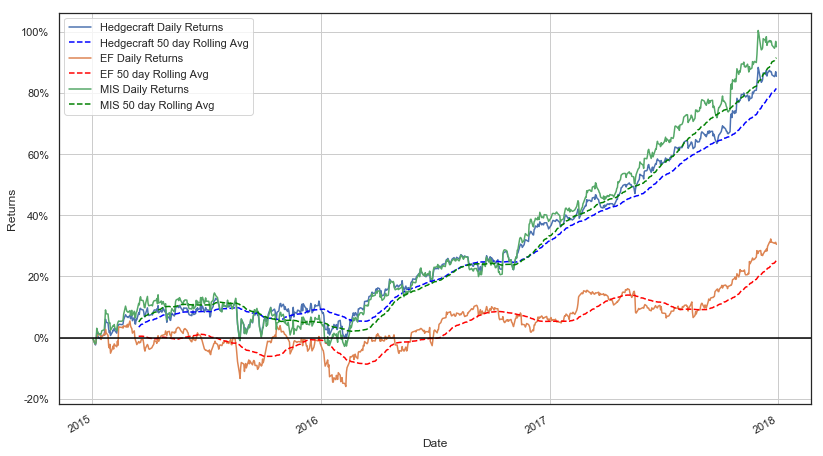

In [93]:
# imports matplotlib submodule to aesthetically place date ticks
from matplotlib.dates import AutoDateFormatter, AutoDateLocator

# initializes figure and axis
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

# gets xtick postions for datetime objects, set minimum number of xticks to 3
xtick_locator = AutoDateLocator(minticks=3)

# aesthetically formats xticks
xtick_formatter = AutoDateFormatter(xtick_locator)

# returns 50 day moving avg for each model
rolling_50d_avg = daily_roi_rate.rename('Hedgecraft 50 day Rolling Avg').rolling(50).mean()
ef_rolling_50d_avg = ef_daily_roi_rate.rename('EF 50 day Rolling Avg').rolling(50).mean()
mis_rolling_50d_avg = mis_daily_roi_rate.rename('MIS 50 day Rolling Avg').rolling(50).mean()

# returns pretty seaborn plot of hedgecraft returns and rolling avg
daily_roi_rate.plot()
rolling_50d_avg.plot(color='blue', ls='dashed')

# returns pretty seaborn plot of EF returns and rolling avg
ef_daily_roi_rate.plot()
ef_rolling_50d_avg.plot(color='red', ls='dashed')

# returns pretty seaborn plot of hedgecraft MIS returns and rolling avg
mis_daily_roi_rate.plot()
mis_rolling_50d_avg.plot(color='green', ls='dashed')

# renders xticks, sets ylabel, and turns legend on
ax.xaxis.set_major_locator(xtick_locator)
ax.xaxis.set_major_formatter(xtick_formatter)
ax.set_ylabel('Returns')
ax.legend()

# gets ytick labels and converts to pct format
vals = ax.get_yticks()
ax.set_yticklabels(['{:.0f}%'.format(x) for x in vals])

# draws a horizontal line at 0, turns grid on
plt.axhline(0, color='black');
plt.grid(True)

In [61]:
backtest_stats

,Hedgecraft,Hedgecraft MIS,Efficient Frontier
Avg Annual Rate of Returns,27.5%,30.0%,9.6%
Annual Volatility,14.6%,17.2%,16.4%
Annualized Sharpe Ratio,1.75,1.63,0.47


In [62]:
backtest_summary

,Hedgecraft Returns,Hedgecraft MIS Returns,Efficient Frontier Returns,Hedgecraft Return Rates,Hedgecraft MIS Return Rates,Efficient Frontier Return Rates
2015,9.8%,5.3%,-1.8%,9.8%,5.3%,-1.8%
2016,36.4%,38.7%,6.2%,26.5%,33.5%,8.1%
2017,85.4%,95.1%,30.5%,49.0%,56.3%,24.3%


In [106]:
prob_lose_money = daily_roi_rate[daily_roi_rate < 0].shape[0] / daily_roi_rate.shape[0]
ef_prob_lose_money = ef_daily_roi_rate[ef_daily_roi_rate < 0].shape[0] / ef_daily_roi_rate.shape[0]
mis_prob_lose_money = mis_daily_roi_rate[mis_daily_roi_rate < 0].shape[0] / mis_daily_roi_rate.shape[0]

rolling_30d_avg = daily_roi_rate.rename('Hedgecraft 30 day Rolling Avg').rolling(30).mean()
ef_rolling_30d_avg = ef_daily_roi_rate.rename('EF 30 day Rolling Avg').rolling(30).mean()
mis_rolling_30d_avg = mis_daily_roi_rate.rename('MIS 30 day Rolling Avg').rolling(30).mean()


rolling_90d_avg = daily_roi_rate.rename('Hedgecraft 90 day Rolling Avg').rolling(90).mean()
ef_rolling_90d_avg = ef_daily_roi_rate.rename('EF 90 day Rolling Avg').rolling(90).mean()
mis_rolling_90d_avg = mis_daily_roi_rate.rename('MIS 90 day Rolling Avg').rolling(90).mean()

rolling_avg_list = [rolling_30d_avg, rolling_50d_avg, rolling_90d_avg]
ef_rolling_avg_list = [ef_rolling_30d_avg, ef_rolling_50d_avg, ef_rolling_90d_avg]
mis_rolling_avg_list = [mis_rolling_30d_avg, mis_rolling_50d_avg, mis_rolling_90d_avg]

prob_below_rolling_avgs = []
for i in rolling_avg_list:
    prob_below_rolling_avgs.append(daily_roi_rate[daily_roi_rate < i].shape[0] / daily_roi_rate.shape[0])
    
ef_prob_below_rolling_avgs = []
for i in ef_rolling_avg_list:
    ef_prob_below_rolling_avgs.append(ef_daily_roi_rate[ef_daily_roi_rate < i].shape[0] / ef_daily_roi_rate.shape[0])

mis_prob_below_rolling_avgs = []
for i in mis_rolling_avg_list:
    mis_prob_below_rolling_avgs.append(mis_daily_roi_rate[mis_daily_roi_rate < i].shape[0] / mis_daily_roi_rate.shape[0])

min_loss = min(daily_roi_rate)
ef_min_loss = min(ef_daily_roi_rate)
mis_min_loss = min(mis_daily_roi_rate)

mean_loss = daily_roi_rate[daily_roi_rate < 0].mean()
ef_mean_loss = ef_daily_roi_rate[ef_daily_roi_rate < 0].mean()
mis_mean_loss = mis_daily_roi_rate[mis_daily_roi_rate < 0].mean()

dist_stats = [prob_lose_money*100, min_loss, mean_loss, prob_below_rolling_avgs[0]*100, 
                prob_below_rolling_avgs[1]*100, prob_below_rolling_avgs[2]*100]
dist_stats = [str(round(x, 2)) + '%' for x in dist_stats]


ef_dist_stats = [ef_prob_lose_money*100, ef_min_loss, ef_mean_loss, ef_prob_below_rolling_avgs[0]*100,
                    ef_prob_below_rolling_avgs[1]*100, ef_prob_below_rolling_avgs[2]*100]
ef_dist_stats = [str(round(x, 2)) + '%' for x in ef_dist_stats]


mis_dist_stats = [mis_prob_lose_money*100, mis_min_loss, mis_mean_loss, mis_prob_below_rolling_avgs[0]*100,
                     mis_prob_below_rolling_avgs[1]*100, mis_prob_below_rolling_avgs[2]*100]
mis_dist_stats = [str(round(x, 2)) + '%' for x in mis_dist_stats]

dist_stats_summary = {'Hedgecraft': dist_stats, 'Hedgecraft MIS': mis_dist_stats, 'Efficient Frontier': ef_dist_stats}
dist_stats_summary = pd.DataFrame.from_dict(dist_stats_summary)
dist_stats_summary = dist_stats_summary.rename(index={0:'probability of losing money', 
                                 1:'minimum loss',
                                 2:'mean loss',
                                 3:'Probability of falling bellow 30 day rolling avg',
                                 4:'Probability of falling bellow 50 day rolling avg',
                                 5:'Probability of falling bellow 90 day rolling avg'
                                }
                         );

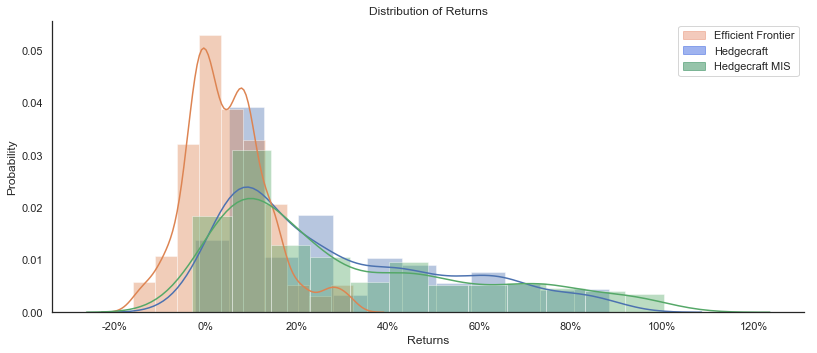

In [64]:
import matplotlib.patches as mpatches

def multi_distplot(rdist1, rdist2, rdist3, kde=True):
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(111)

    sns.distplot(rdist1, bins=12, kde=bool)
    sns.distplot(rdist2, bins=10, kde=bool)
    sns.distplot(rdist3, bins=12, kde=bool)
    vals1 = ax.get_xticks()
    ax.set_xticklabels(['{:.0f}%'.format(x) for x in vals1])
    ax.set_ylabel('Probability')
    ax.set_xlabel('Returns')
    plt.title('Distribution of Returns')
    sns.despine(top=True, right=True)

    ef_patch = mpatches.Patch(color='darksalmon', label='Efficient Frontier', alpha=0.5)
    patch = mpatches.Patch(color='royalblue', label='Hedgecraft', alpha=0.5)
    mis_patch = mpatches.Patch(color='seagreen', label='Hedgecraft MIS', alpha=0.5)
    plt.legend(handles=[ef_patch, patch, mis_patch])
    
multi_distplot(rdist1 = daily_roi_rate, rdist2 = ef_daily_roi_rate, rdist3 = mis_daily_roi_rate)

In [107]:
dist_stats_summary

,Hedgecraft,Hedgecraft MIS,Efficient Frontier
probability of losing money,1.59%,2.91%,33.77%
minimum loss,-2.39%,-2.87%,-15.99%
mean loss,-0.77%,-1.41%,-4.17%
Probability of falling bellow 30 day rolling avg,21.32%,25.56%,38.41%
Probability of falling bellow 50 day rolling avg,16.56%,21.59%,38.01%
Probability of falling bellow 90 day rolling avg,11.79%,18.81%,35.1%


## Hedgecraft Portfolio Statistics

In comparison, the Dow had a 0.10%, 16.28%, and 27.97% annual return rate in 2015, 16, and 17 respectively. The S&P500 had a -0.73%, 9.54%, and 19.42% annual return rate in the same respective years. **Our historical portfolio significantly outperformed both indexes with a 19.29% average annual return rate, a 12.6% annualized standard deviation, and a Sharpe ratio of 1.38.** Keep in mind we built our portfolio with a single asset type and without any substantial research into company fundamentals (intentionally adding poor performing stocks for the sake of analysis).

## Markowitz Portfolio Statistics

In comparison, the Dow had a 0.10%, 16.28%, and 27.97% annual return rate in 2015, 16, and 17 respectively. The S&P500 had a -0.73%, 9.54%, and 19.42% annual return rate in the same respective years. The Markowitz portfolio slightly underperformed the market. Needless to say, our Hedgecrafted portfolio **substantially** outperformed the Markowitz portfolio.

# Conclusion

In section I. we cleaned and preprocessed the data for time series analysis. In section II. we transformed the data into a distance correlation network and visualized how our model portfolio is correlated with itself. In section III. we built a centrality-based intraportfolio risk model, defining the asset weights as the inverse of the "relative risk." In section IV. we validated the model in 2015, 2016, and 2017 where it outperformed the DIJA and S&P500 indexes and the Markowitz portfolio. In conclusion, we highly recommend Dailo invests considerable resources into further development and validation of this model. Next steps would include generous web scraping and API mining of many asset classes and types, building a Hedgecraft API to effortlessly reproduce the work of this notebook, generating a set of diversified portfolios and observing how each one behaves over longer periods of time, and examining how they perform in financial crises (e.g. the 2008 housing crisis). Further steps would include observing how asset correlation networks evolve in time and developing machine learning-based link prediction algorithms.